In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import *
import tensorflow_addons as tfa
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Hyperparameters

In [7]:
BEST_PATH = './models/ffnn_raw.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.001
EPSILON = 1e-06
BATCH_SIZE = 16

# Data loading

In [8]:
l = np.load('./results/2020_W/fw_ct_dataset.npz', allow_pickle=True)
data_indices = l['data_indices']
input_data = l['input_data']
output_label = l['output_label']
INPUT_MAXS = l['INPUT_MAXS']
INPUT_MINS = l['INPUT_MINS']
OUTPUT_MAX = l['OUTPUT_MAX']
OUTPUT_MIN = l['OUTPUT_MIN']

In [9]:
input_data = input_data.astype('float32')
output_label = output_label.astype('float32')

In [10]:
input_data = input_data.reshape(input_data.shape[0], -1)

In [11]:
print(input_data.shape)
print(output_label.shape)

(456, 1296)
(456, 1)


In [12]:
print(INPUT_MAXS)
print(INPUT_MINS)

[  42.31875   99.      1313.3       78.755     10.006      5.057
   36.58      55.877     19.731  ]
[11.5     4.4325 -0.5957 32.115   0.205   0.112  11.53    8.744  11.393 ]


In [13]:
print(OUTPUT_MAX)
print(OUTPUT_MIN)

2.5180414673761202
0.31621880464190666


In [14]:
N_TRAIN = int(input_data.shape[0]*.09)
N_DEV = int(input_data.shape[0]/3)
TRAIN_INDEX = [_ for _ in range(N_TRAIN)] + \
              [_ for _ in range(N_DEV, N_DEV+N_TRAIN)] + \
              [_ for _ in range(N_DEV*2, N_DEV*2+N_TRAIN)]
TEST_INDEX = [_ for _ in range(input_data.shape[0]) if _ not in TRAIN_INDEX]
train_input = input_data[TRAIN_INDEX, ...]
train_label = output_label[TRAIN_INDEX, ...]
train_indices = data_indices[TRAIN_INDEX]
test_input = input_data[TEST_INDEX, ...]
test_label = output_label[TEST_INDEX, ...]
test_indices = data_indices[TEST_INDEX]

In [15]:
train_indices, val_indices, train_input, val_input, train_label, val_label = train_test_split(train_indices, train_input, train_label, test_size=0.3, shuffle=True, random_state=3101)

In [16]:
print(f'number of data set: {input_data.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')
print(f'number of test set: {test_input.shape[0]}')

number of data set: 456
number of training set: 86
number of validation set: 37
number of test set: 333


In [17]:
with strategy.scope():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
    train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
    val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)

# Model construction

In [18]:
with strategy.scope():
    model = models.Sequential([
        layers.Dense(512, activation=tf.nn.sigmoid),
        layers.BatchNormalization(),
        layers.Dense(512, activation=tf.nn.sigmoid),
        layers.BatchNormalization(),
        layers.Dense(32),
        layers.Dense(1)
    ])

In [19]:
cbs = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.1, patience=5, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0)

save = callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)

In [20]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model.compile(optimizer=opt, loss='mae')
    model.fit(train_dataset, epochs=TRAINING_EPOCHS, validation_data=val_dataset,
                  verbose=1, callbacks=[cbs, save, early_stop]) 

Epoch 1/200
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
1/6 [====>.........................] - ETA: 0s - loss: 1.5425INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:

In [21]:
model.load_weights(BEST_PATH)

In [22]:
model.evaluate(val_dataset)

3/3 [==============================] - 0s 2ms/step - loss: 0.0611


0.06110256910324097

In [23]:
pred_output = model.predict(test_input)

In [24]:
pred_output = pred_output*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN
test_label = test_label*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN

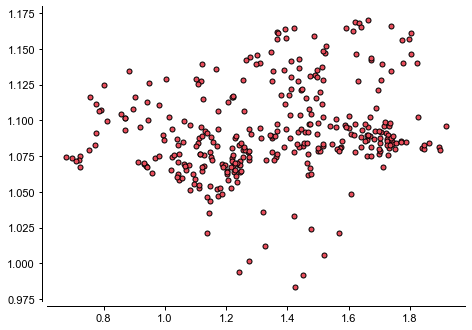

In [25]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(test_label, pred_output, 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [26]:
pred_df = pd.DataFrame(test_label, index=test_indices[:, 0], columns=['label'])
pred_df['pred'] = pred_output

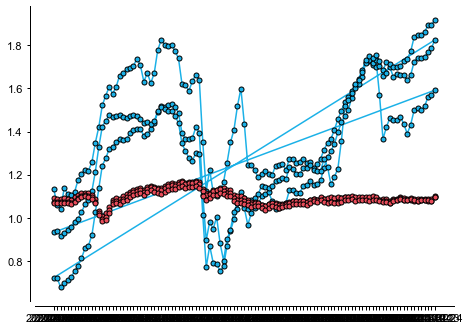

In [27]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['label'], '-o', ms=5, mec='k', c=cmap[4])
ax0.plot(pred_df.index, pred_df['pred'], 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [28]:
pred_df.to_csv('./results/model_output/ffnn_raw.csv')